In [1]:
import numpy as np
import pandas as pd

import pydicom as dicom
import matplotlib.pylab as plt
import matplotlib.patches as patches

import pickle

import os
from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18


from torchsummary import summary

import gc
gc.collect()

import cv2

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

from PIL import Image

import matplotlib.pyplot as plt
from IPython.display import clear_output

from graphviz import Digraph

In [2]:
print(f"Cuda доступна {torch.cuda.is_available()}. Версия cuda {torch.version.cuda}")

gpu_id = 0
gpu_str = "cuda:{}".format(gpu_id)
device = torch.device(gpu_str if torch.cuda.is_available() else "cpu")

x_cpu = torch.ones((3, 3))
idx_cpus = set()
devices_cpu = {}
devices_gpu = {}

for idx in range(1000):
    device = torch.device(f"cpu:{idx}")
    x_cpu = x_cpu.to(device)
    if id(x_cpu) not in idx_cpus:
        idx_cpus.add(id(x_cpu))
        devices_cpu[f"cpu:{idx}"] = device
        print("x_cpu:{} device: {} is_cuda: {} id: {}".format(idx, x_cpu.device, x_cpu.is_cuda, id(x_cpu)))
    else:
        break
        
device_count = torch.cuda.device_count()

print("\ndevice_count: {}".format(device_count))

print(f"Используется cuda:{torch.cuda.current_device()}")
print(torch.cuda.device_count())

for idx in range(torch.cuda.device_count()):
    try:
        device = torch.device(f"cuda:{idx}")
        x_gpu = x_cpu.to(device)
        print("x_gpu:\ndevice: {} is_cuda: {} id: {}".format(x_gpu.device, x_gpu.is_cuda, id(x_gpu)))
        device_name = torch.cuda.get_device_name(idx)
        print("\ndevice_name {}: {}".format(idx, device_name))
        #print(torch.cuda.memory_stats(device))
        print(torch.cuda.get_device_capability(idx))
        devices_gpu[f"cuda:{idx}"] = (device_name, device)
    except Exception as e:
        print(f"Карта {idx} не отвечает - {e}")

Cuda доступна True. Версия cuda 10.2
x_cpu:0 device: cpu is_cuda: False id: 140634064514480
x_cpu:1 device: cpu is_cuda: False id: 140637853619920

device_count: 4
Используется cuda:0
4
x_gpu:
device: cuda:0 is_cuda: True id: 140637836247824

device_name 0: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:1 is_cuda: True id: 140637836628272

device_name 1: Tesla M40
(5, 2)
x_gpu:
device: cuda:2 is_cuda: True id: 140637853637184

device_name 2: Tesla M40 24GB
(5, 2)
x_gpu:
device: cuda:3 is_cuda: True id: 140637836247824

device_name 3: NVIDIA GeForce GT 1030
(6, 1)


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
params = {
    "data_pandas":"",
    "dicom_path":"./DataBase/",
    "size":128,
    'batch_size':8,
    'num_workers':1,
    "epoch":5,
    'device':torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [5]:
params['data_pandas'] =  os.path.join(params["dicom_path"], [f for f in listdir(params["dicom_path"]) if isfile(join(params["dicom_path"], f)) if f.split('.')[-1] == 'xls'][0])

(512, 512)


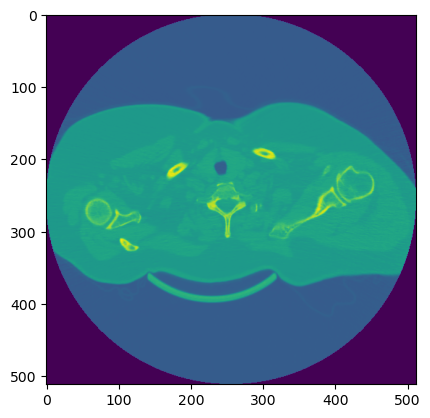

In [6]:
image_path = os.path.join(params["dicom_path"],'Examples/1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900/1.2.643.5.1.13.13.12.2.77.8252.03010208081102131112140005050712/1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411.dcm')
ds = dicom.dcmread(image_path)
print(np.shape(ds.pixel_array))
plt.imshow(ds.pixel_array);

In [7]:
ds.fix_meta_info

/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: The value length (156) exceeds the maximum length of 64 allowed for VR LO.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/home/arhitegio/anaconda3/lib/python3.9/site-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '1.2.643.5.1.13.13.12.2.77.8252.0

<bound method Dataset.fix_meta_info of Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 228
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.643.5.1.13.13.12.2.77.8252.01011513131309010807001403090411
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.392.200036.9116.2.6.1.100
(0002, 0013) Implementation Version Name         SH: 'TM_CT_CMW_V3.00'
(0002, 0016) Source Application Entity Title     SH: 'ANET1_GKB50'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID 

In [8]:
params

{'data_pandas': './DataBase/labels.xls',
 'dicom_path': './DataBase/',
 'size': 128,
 'batch_size': 8,
 'num_workers': 1,
 'epoch': 5,
 'device': device(type='cuda', index=0)}

In [9]:
xl = pd.ExcelFile(params["data_pandas"])
xl.sheet_names

['Sheet1']

In [10]:
df = xl.parse(xl.sheet_names[0])
df.head()

,study_id,study_uid,hydrothorax type III,lymphadenopathy type III,sarcoidosis type III,tuberculosis type III,aortic aneurysm type III,emphysema type III,pulmonary trunk dilation type III,healthy
0,1,1.2.643.5.1.13.13.12.2.77.8252.130711130205111...,1,0,0,0,0,0,0,0
1,2,1.2.643.5.1.13.13.12.2.77.8252.120707110114061...,1,0,0,0,0,0,0,0
2,3,1.2.643.5.1.13.13.12.2.77.8252.000212131307091...,0,0,0,0,0,0,0,1
3,4,1.2.643.5.1.13.13.12.2.77.8252.101304140007110...,0,0,0,0,0,0,0,1
4,5,1.2.643.5.1.13.13.12.2.77.8252.041501100205001...,1,0,0,0,0,0,0,0


In [11]:
df[df.columns[1:]].to_numpy()

array([['1.2.643.5.1.13.13.12.2.77.8252.13071113020511100909130002030902',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.12070711011406140711090811071403',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900',
        0, 0, 0, 0, 0, 0, 0, 1],
       ['1.2.643.5.1.13.13.12.2.77.8252.10130414000711011208060413151200',
        0, 0, 0, 0, 0, 0, 0, 1],
       ['1.2.643.5.1.13.13.12.2.77.8252.04150110020500101206140607040008',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.12150202040610130306061415070810',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.06021315080301150408151203010510',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.06020305101012000608131510110403',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.12.2.77.8252.02150609090501100010060615121212',
        1, 0, 0, 0, 0, 0, 0, 0],
       ['1.2.643.5.1.13.13.1

In [12]:
files = [{"study_uid":dp.split('/')[-2], "path_dicom":os.path.join(dp, f)} for dp, dn, filenames in os.walk(os.path.join(params["dicom_path"], "Examples")) for f in filenames if os.path.splitext(f)[1] == '.dcm']

In [13]:
len(files)

14290

In [14]:
df_ = pd.DataFrame(files)

In [15]:
df

,study_id,study_uid,hydrothorax type III,lymphadenopathy type III,sarcoidosis type III,tuberculosis type III,aortic aneurysm type III,emphysema type III,pulmonary trunk dilation type III,healthy
0,1,1.2.643.5.1.13.13.12.2.77.8252.130711130205111...,1,0,0,0,0,0,0,0
1,2,1.2.643.5.1.13.13.12.2.77.8252.120707110114061...,1,0,0,0,0,0,0,0
2,3,1.2.643.5.1.13.13.12.2.77.8252.000212131307091...,0,0,0,0,0,0,0,1
3,4,1.2.643.5.1.13.13.12.2.77.8252.101304140007110...,0,0,0,0,0,0,0,1
4,5,1.2.643.5.1.13.13.12.2.77.8252.041501100205001...,1,0,0,0,0,0,0,0
5,6,1.2.643.5.1.13.13.12.2.77.8252.121502020406101...,1,0,0,0,0,0,0,0
6,7,1.2.643.5.1.13.13.12.2.77.8252.060213150803011...,1,0,0,0,0,0,0,0
7,8,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,1,0,0,0,0,0,0,0
8,9,1.2.643.5.1.13.13.12.2.77.8252.021506090905011...,1,0,0,0,0,0,0,0
9,10,1.2.643.5.1.13.13.12.2.77.8252.070110140208140...,1,0,0,0,0,0,0,0


In [16]:
df_

,study_uid,path_dicom
0,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
1,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
2,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
3,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
4,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
...,...,...
14285,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
14286,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
14287,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....
14288,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....


In [17]:
data = df_.merge(df[df.columns[1:]], how='inner', on="study_uid")

In [18]:
data

,study_uid,path_dicom,hydrothorax type III,lymphadenopathy type III,sarcoidosis type III,tuberculosis type III,aortic aneurysm type III,emphysema type III,pulmonary trunk dilation type III,healthy
0,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,1,0,0,0,0,0,0,0
1,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,1,0,0,0,0,0,0,0
2,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,1,0,0,0,0,0,0,0
3,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,1,0,0,0,0,0,0,0
4,1.2.643.5.1.13.13.12.2.77.8252.060203051010120...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
14285,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,0,0,1,0,0,0,0,0
14286,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,0,0,1,0,0,0,0,0
14287,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,0,0,1,0,0,0,0,0
14288,1.2.643.5.1.13.13.12.2.77.8252.121305090905130...,./DataBase/Examples/1.2.643.5.1.13.13.12.2.77....,0,0,1,0,0,0,0,0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14290 entries, 0 to 14289
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   study_uid                          14290 non-null  object
 1   path_dicom                         14290 non-null  object
 2   hydrothorax type III               14290 non-null  int64 
 3   lymphadenopathy type III           14290 non-null  int64 
 4   sarcoidosis type III               14290 non-null  int64 
 5   tuberculosis type III              14290 non-null  int64 
 6   aortic aneurysm type III           14290 non-null  int64 
 7   emphysema type III                 14290 non-null  int64 
 8   pulmonary trunk dilation type III  14290 non-null  int64 
 9   healthy                            14290 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 1.2+ MB


In [20]:
list(data.columns)[2:]

['hydrothorax type III',
 'lymphadenopathy type III',
 'sarcoidosis type III',
 'tuberculosis type III',
 'aortic aneurysm type III',
 'emphysema type III',
 'pulmonary trunk dilation type III',
 'healthy']

In [21]:
params['all_class'] = list(data.columns)[2:]

In [22]:
data.groupby(data["study_uid"]).agg({'hydrothorax type III':["sum"], 'lymphadenopathy type III':["sum"],'sarcoidosis type III':["sum"], 'tuberculosis type III':["sum"], 'aortic aneurysm type III':["sum"], 'emphysema type III':["sum"], 'pulmonary trunk dilation type III':["sum"], 'healthy':["sum"]})

,hydrothorax type III,lymphadenopathy type III,sarcoidosis type III,tuberculosis type III,aortic aneurysm type III,emphysema type III,pulmonary trunk dilation type III,healthy
,sum,sum,sum,sum,sum,sum,sum,sum
study_uid,,,,,,,,
1.2.643.5.1.13.13.12.2.77.8252.00021213130709131100130009100900,0,0,0,0,0,0,0,426
1.2.643.5.1.13.13.12.2.77.8252.00021513050411021503000908100411,0,0,0,0,0,0,0,580
1.2.643.5.1.13.13.12.2.77.8252.02150609090501100010060615121212,211,0,0,0,0,0,0,0
1.2.643.5.1.13.13.12.2.77.8252.03060715021510030815021011120413,0,338,0,0,0,0,0,0
1.2.643.5.1.13.13.12.2.77.8252.04150110020500101206140607040008,2,0,0,0,0,0,0,0
1.2.643.5.1.13.13.12.2.77.8252.06020305101012000608131510110403,476,0,0,0,0,0,0,0
1.2.643.5.1.13.13.12.2.77.8252.06021315080301150408151203010510,2,0,0,0,0,0,0,0
1.2.643.5.1.13.13.12.2.77.8252.06091508010203100707150211120015,0,0,426,0,0,0,0,0


In [23]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=43)

In [24]:
train_df.columns

Index(['study_uid', 'path_dicom', 'hydrothorax type III',
       'lymphadenopathy type III', 'sarcoidosis type III',
       'tuberculosis type III', 'aortic aneurysm type III',
       'emphysema type III', 'pulmonary trunk dilation type III', 'healthy'],
      dtype='object')

In [25]:
dicom_path, label = train_df.iloc[0]['path_dicom'], train_df.iloc[0][params['all_class']]

In [26]:
dicom_image = Image.fromarray(dicom.dcmread(dicom_path).pixel_array)

In [27]:
arr = dicom.dcmread(dicom_path).pixel_array

In [28]:
np.min(arr), np.max(arr), np.median(arr), np.mean(arr)

(-2048, 1822, -858.0, -821.276683807373)

In [29]:
glb_ = { "min":[], "max":[], "mean":[], "median":[] }

In [30]:
pbar_progress = tqdm_step(range(len(train_df)), desc="Прогресс")

for idx in pbar_progress:
    dicom_path, label = train_df.iloc[idx]['path_dicom'], train_df.iloc[idx][params['all_class']]
    arr = dicom.dcmread(dicom_path).pixel_array
    glb_['min'].append(np.min(arr))
    glb_['max'].append(np.max(arr))
    glb_['median'].append(np.median(arr))
    glb_['mean'].append(np.mean(arr))

Прогресс:   0%|          | 0/11432 [00:00<?, ?it/s]

In [31]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform
        
    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        
        dicom_path, label = self.data_df.iloc[idx]['path_dicom'], self.data_df.iloc[idx][params['all_class']].to_numpy()
        #print(np.shape(dicom.dcmread(dicom_path).pixel_array))
        dicom_arr = dicom.dcmread(dicom_path).pixel_array
        while len(np.shape(dicom_arr)) > 2:
            dicom_arr = dicom_arr[0, ...]
            
        dicom_image = Image.fromarray(dicom_arr)
        #print(params['size'])
        #print(np.shape(dicom_image), np.min(dicom_image), np.max(dicom_image), np.mean(dicom_image), np.median(dicom_image))
        dicom_image = dicom_image.resize((params['size'], params['size']))#, resample=Image.Resampling.BOX)
        #print(np.shape(dicom_image))
        #print(1)
        if self.transform:
            dicom_image = self.transform(dicom_image)
        #print(2)
        #print(torch.typename(dicom_image))
        return dicom_image.float(), torch.tensor(label.astype("int32")), dicom_path

In [32]:
df_gbl = pd.DataFrame(glb_)

In [33]:
df_gbl

,min,max,mean,median
0,-2048,1822,-821.276684,-858.0
1,-2048,1337,-804.407566,-879.0
2,-2048,1457,-796.692413,-887.0
3,-2048,2213,-804.232864,-864.0
4,0,2982,521.263614,215.0
...,...,...,...,...
11427,-2048,1919,-782.544952,-891.0
11428,-2048,2260,-847.349998,-923.0
11429,0,3001,579.758552,334.0
11430,-2048,2116,-867.615654,-908.0


In [34]:
train_transform = transforms.Compose([
    #trf.ToPILImage(),
    #transforms.Resize((params['size'], params['size'])),
    #trf.Resize((512, 512)),
    #transforms.Resize((int(params['size'] * 1.3), int(params['size'] * 1.3))),
    #trf.Resize((int(params['size']), int(params['size']))),
    #transforms.RandomCrop((params['size'], params['size'])),
    transforms.RandomRotation(degrees=3.0, fill=np.min(df_gbl['min'])),
    transforms.RandomAffine(degrees=(-2,2), translate=(0, 0.15), scale=(0.90, 1.0), fill=np.min(df_gbl['min'])),
    #trf.RandomApply(transforms=[trf.ElasticTransform(alpha=50.0)], p=0.5),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.02, hue=0.02), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])
valid_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.Resize((params['size'], params['size'])),
    #transforms.RandomResizedCrop(params['size']),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

In [35]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [36]:
np.shape(train_dataset[0])

/home/arhitegio/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/home/arhitegio/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(3,)

In [37]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=params['batch_size'],
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=params['batch_size'],
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=params['num_workers'])

In [38]:
batch_size = 4
epochs = 10
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [39]:
def metric_accuracy(y_true, pred, device):
    #print(np.shape(y_true))
    #print(np.shape(torch.argmax(y_true, dim=0)))
    #print(np.shape(torch.argmax(y_true, dim=-1)))
    #print(torch.argmax(y_true, dim=0) == torch.argmax(pred, dim=0).float())
    return torch.mean((torch.argmax(y_true, dim=-1) == torch.argmax(pred, dim=-1)).float())

In [40]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        self.bn2d2.to(device)

    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [82]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size, device):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.conv1.to(device)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d1.to(device)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.conv2.to(device)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.bn2d2.to(device)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        self.conv3.to(device)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(80, 64)
        self.linear1.to(device)
        self.linear2 = nn.Linear(64, 32)
        self.linear2.to(device)
        self.linear3 = nn.Linear(32, len(params["all_class"]))
        self.linear3.to(device)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.sigmoid(self.conv3(out))
        out = self.flatten(out)
        out = torch.sigmoid(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = torch.nn.functional.softmax(self.linear3(out))
        return out

In [83]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels, device):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 48, 3, device)
        self.conv1.to(device)
        self.conv2 = DownSampling(48, 36, 3, device)
        self.conv2.to(device)
        self.conv3 = DownSampling(36, 32, 3, device)
        self.conv3.to(device)
        self.conv4 = DownSampling(32, 28, 3, device)
        self.conv4.to(device)
        self.final = FinalBlock(28, 24, 20, out_channels, device)
        self.final.to(device)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_maxpool.to(device)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        x = self.conv4(x)
        x = self.conv_maxpool(x)
        x = self.final(x)
        return x

In [84]:
def step(inputs, labels, optimizer, criterion, device, is_train=True):
    #if is_train:
    optimizer.zero_grad()

    outputs = unet(inputs)
    #print(np.shape(outputs), np.shape(labels))
    #outputs = outputs.permute(0, 2, 3, 1)
    #labels = labels.permute(0, 2, 3, 1)
    
    #loss = criterion(torch.argmax(outputs, dim=0).float(), torch.argmax(labels.float(), dim=0).float())
    loss = criterion(outputs, labels.float())
    
    if is_train:
        loss.backward()
        optimizer.step()
    return loss.item(), metric_accuracy(labels, outputs, device).item()

In [85]:
learning_rate = 0.0001

In [86]:
unet = UNet(in_channels=1,out_channels=5, device=params["device"])
#if params['device'] != "cpu":
#unet = unet.to(params["device"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [87]:
unet.to(params["device"])

UNet(
  (conv1): DownSampling(
    (conv1): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): DownSampling(
    (conv1): Conv2d(48, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d2): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): DownSampling(
    (conv1): Conv2d(36, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2d1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stri

In [88]:
acc_train_total = []
loss_train_total = []
acc_val_total = []
loss_val_total = []

In [442]:
try:
    print(unet.load_state_dict(torch.load('./best_model_gidratorax.mdl')))
except:
    print("Модель не загрузилась")

Модель не загрузилась


In [443]:
try:
    acc_train_total = list(np.load('acc_gidratorax_train_total.npy'))
    loss_train_total = list(np.load('loss_gidratorax_train_total.npy'))
    acc_val_total = list(np.load('acc_gidratorax_val_total.npy'))
    loss_val_total = list(np.load('loss_gidratorax_val_total.npy'))
except:
    print("Данные не загрузилась")

Данные не загрузилась


In [100]:
learning_rate = 0.00005

In [90]:
criterion = nn.BCELoss()

In [91]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [93]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        #try:
            batch_train_x = batch_train_x.to(params["device"])
            batch_train_y = batch_train_y.to(params["device"])
            batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
            bar_train_loss.append(batch_loss)
            bar_train_acc.append(metric_acc)
            pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
            torch.cuda.empty_cache()
            gc.collect()
        #except Exception as e:
        #    pass
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

CPU times: user 16min 44s, sys: 2min 17s, total: 19min 1s
Wall time: 19min 1s


In [96]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        #try:
            batch_train_x = batch_train_x.to(params["device"])
            batch_train_y = batch_train_y.to(params["device"])
            batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
            bar_train_loss.append(batch_loss)
            bar_train_acc.append(metric_acc)
            pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
            torch.cuda.empty_cache()
            gc.collect()
        #except Exception as e:
        #    pass
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

CPU times: user 16min 55s, sys: 2min 17s, total: 19min 12s
Wall time: 19min 12s


In [97]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        #try:
            batch_train_x = batch_train_x.to(params["device"])
            batch_train_y = batch_train_y.to(params["device"])
            batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
            bar_train_loss.append(batch_loss)
            bar_train_acc.append(metric_acc)
            pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
            torch.cuda.empty_cache()
            gc.collect()
        #except Exception as e:
        #    pass
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

CPU times: user 17min 19s, sys: 2min 18s, total: 19min 38s
Wall time: 19min 38s


In [101]:
%%time

acc_train  = []
loss_train = []
acc_val    = []
loss_val   = []
batch_loss = 0
metric_acc = 0
pbar_epochs = tqdm_step(range(params["epoch"]), desc="Epochs")
for _ in pbar_epochs:
    unet.train()
    bar_train_loss = []
    bar_train_acc = []
    pbar_steps = tqdm_step(train_loader, desc="Training")
    for batch_train_x, batch_train_y, batch_train_name_file in pbar_steps:
        #batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        #batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        #print(np.shape(batch_train_x), np.shape(batch_train_y), np.shape(batch_train_name_file))
        #if use_gpu:
        #try:
            batch_train_x = batch_train_x.to(params["device"])
            batch_train_y = batch_train_y.to(params["device"])
            batch_loss, metric_acc = step(batch_train_x, batch_train_y, optimizer, criterion, params["device"], is_train=True)
            bar_train_loss.append(batch_loss)
            bar_train_acc.append(metric_acc)
            pbar_steps.postfix = f"loss = {batch_loss}, acc = {metric_acc*100}%, loss_mean = {np.mean(bar_train_loss)}, acc_mean = {np.mean(bar_train_acc)*100}%"     
            torch.cuda.empty_cache()
            gc.collect()
        #except Exception as e:
        #    pass
        #break
    loss_train.append(np.mean(bar_train_loss))
    acc_train.append(np.mean(bar_train_acc))
    
    unet.eval()
    with torch.no_grad():
        pbar_vals = tqdm_step(valid_loader, desc="Predicting")
        bar_val_loss = []
        bar_val_acc = []
        for batch_val_x, batch_val_y, batch_val_name_file in pbar_vals:
            #try:
                #print(np.shape(batch_val_x), np.shape(batch_val_y), np.shape(batch_val_name_file))
                #batch_val_x = torch.from_numpy(x_val[i * batch_size : (i + 1) * batch_size, ...]).float()
                #batch_val_y = torch.from_numpy(y_val[i * batch_size : (i + 1) * batch_size]).long()
                #if use_gpu:
                batch_val_x = batch_val_x.to(params["device"])
                batch_val_y = batch_val_y.to(params["device"])
                batch_loss, metric_acc = step(batch_val_x, batch_val_y, optimizer, criterion, params["device"], is_train=False)
                bar_val_loss.append(batch_loss)
                bar_val_acc.append(metric_acc)
                pbar_vals.postfix = f"loss = {batch_loss},  acc = {metric_acc*100}%, loss_mean = {np.mean(bar_val_loss)}, acc_mean = {np.mean(bar_val_acc)*100}%"
                torch.cuda.empty_cache()
                gc.collect()
            #except Exception as e:
            #    print(e)
    loss_val.append(np.mean(bar_val_loss))
    acc_val.append(np.mean(bar_val_acc))
    pbar_epochs.postfix = f"train_loss = {loss_train[-1]}, train_acc = {acc_train[-1]*100}%, val_loss = {loss_val[-1]}, val_acc = {acc_val[-1]*100}%"
acc_train_total.append(acc_train)
loss_train_total.append(loss_train)
acc_val_total.append(acc_val)
loss_val_total.append(loss_val)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))


Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

Training:   0%|          | 0/1429 [00:00<?, ?it/s]

Predicting:   0%|          | 0/358 [00:00<?, ?it/s]

CPU times: user 17min 17s, sys: 2min 27s, total: 19min 45s
Wall time: 19min 45s


In [102]:
arr_pred = []
y_true = []
y_pred = []
for idx in range(len(valid_dataset)):
    x, y, name_file = valid_dataset[idx]
    x = torch.tensor(np.array([x.detach().cpu().numpy()])).to(params["device"])
    y_p = unet(x.to(params["device"])).squeeze(0).detach().cpu().numpy()
    y_true.append(np.argmax(y).item())
    y_pred.append(np.argmax(y_p))
    arr_pred.append(np.argmax(y).item() == np.argmax(y_p))

/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))
/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))
/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))
/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.softmax(self.linear3(out))
/tmp/ipykernel_3500/510630209.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an 

In [103]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1]])

2845

In [104]:
len([e for e in zip(y_true, y_pred) if e[0] == e[1] and e[0] == 1])

208

In [105]:
len([e for e in zip(y_true, y_pred) if e[0] != e[1]])

13

In [106]:
from sklearn.metrics import f1_score, accuracy_score

In [107]:
print(f"F1 = {f1_score(y_true, y_pred, average='macro')}, точность = {accuracy_score(y_true, y_pred)}")

F1 = 0.996205431622827, точность = 0.9954513645906228


In [108]:
print("Максимальная точность на тренировочных примерах: ")
print("точность: " + str(np.max(np.hstack(acc_train_total))) + ", loss:" + str(np.max(np.hstack(loss_train_total))))

Максимальная точность на тренировочных примерах: 
точность: 0.9923897830650805, loss:1.9443245302804957


In [109]:
print("Максимальная точность на тестовых примерах: ")
print("точность: " + str(np.max(np.hstack(acc_val_total))) + ", loss:" + str(np.max(np.hstack(loss_val_total))))

Максимальная точность на тестовых примерах: 
точность: 0.9979050279329609, loss:1.8966244672263801


In [110]:
print("Средняя точность на тренировочных из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_train_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_train_total[-10:-1]))))

Средняя точность на тренировочных из 10 последних примеров: 
точность: 0.7980305908227532, loss:1.482022468099639


In [111]:
print("Средняя точность на тестовых из 10 последних примеров: ")
print("точность: " + str(np.mean(np.hstack(acc_val_total[-10:-1]))) + ", loss:" + str(np.mean(np.hstack(loss_val_total[-10:-1]))))

Средняя точность на тестовых из 10 последних примеров: 
точность: 0.8, loss:1.4805559185439836


In [112]:
acc_train_total = [e for e in acc_train_total if type(e) == list]
acc_val_total = [e for e in acc_val_total if type(e) == list]

In [113]:
loss_train_total = [e for e in loss_train_total if type(e) == list]
loss_val_total = [e for e in loss_val_total if type(e) == list]

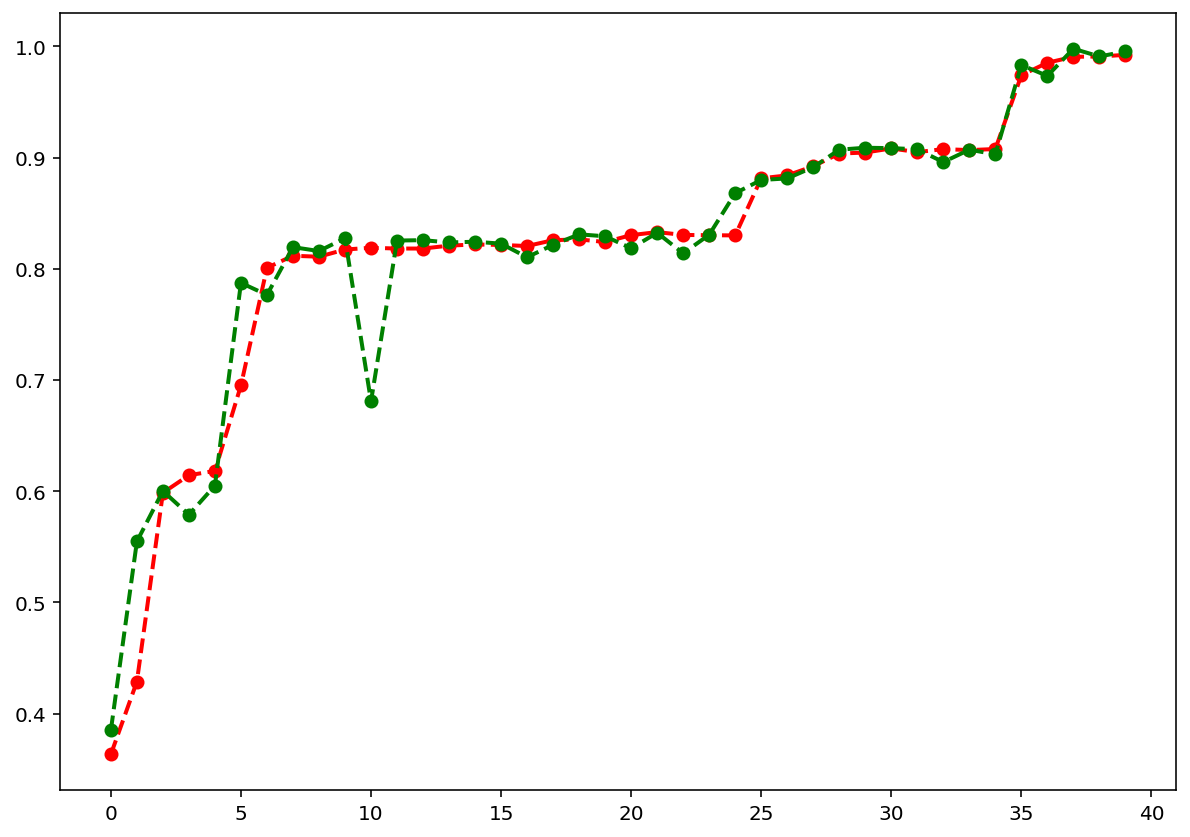

In [114]:
plt.figure(figsize=(10,7), dpi=144)
plt.plot([e for e in range(np.shape(np.hstack(acc_train_total))[0])], np.hstack(acc_train_total), color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.plot([e for e in range(np.shape(np.hstack(acc_val_total))[0])], np.hstack(acc_val_total), color='green', marker='o', linestyle='dashed', linewidth=2, markersize=6)
plt.show()